# Prediksi Kualitas Udara dengan Algoritma Support Vector Machine (SVM).

### Import Library

In [352]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
import joblib
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler


## Dataset

Dataset ISPU di SPKU Jakarta tahun 2021 diambil dari situs Jakarta Open Data. Dataset tersebut terbagi berdasarkan rentang waktu per bulan. Dataset dari masing-masing bulan akan digabungkan menjadi satu dataframe. Berdasarkan deskripsi yang diberikan pada situs tersebut, Dataset ini berisi mengenai Indeks Standar Pencemar Udara (ISPU) yang diukur dari 5 stasiun pemantau kualitas udara (SPKU) yang ada di Provinsi DKI Jakarta Tahun 2021.

Penjelasan variabel dari data diatas sebagai berikut :

1. tanggal : Tanggal pengukuran kualitas udara
2. stasiun : Lokasi pengukuran di stasiun
3. pm10 : Partikulat salah satu parameter yang diukur
4. pm25 : Partikulat salah satu parameter yang diukur
5. so2 : Sulfida (dalam bentuk SO2) salah satu parameter yang diukur
6. co : Carbon Monoksida salah satu parameter yand diukur
7. o3 : Ozon salah satu parameter yang diukur
8. no2 : NItrogen dioksida salah satu parameter yang diukur
9. max : Nilai ukur paling tinggi dari seluruh parameter yang diukur dalam waktu yang sama
10. critical : Parameter yang hasil pengukurannya paling tinggi
11. categori : Kategori hasil perhitungan indeks standar pencemaran udara

In [353]:
df = pd.read_csv("data/ispu_jakarta.csv")

In [354]:
df.head()

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-01-01,DKI4 (Lubang Buaya),41.0,NaN,37.0,14.0,35.0,4.0,41,PM10,BAIK
1,2021-01-01,DKI1 (Bunderan HI),38.0,53.0,29.0,6.0,31.0,13.0,53,PM25,SEDANG
2,2021-01-02,DKI1 (Bunderan HI),27.0,46.0,27.0,7.0,47.0,7.0,47,O3,BAIK
3,2021-01-03,DKI1 (Bunderan HI),44.0,58.0,25.0,7.0,40.0,13.0,58,PM25,SEDANG
4,2021-01-04,DKI1 (Bunderan HI),30.0,48.0,24.0,4.0,32.0,7.0,48,PM25,BAIK


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775 entries, 0 to 774
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tanggal   775 non-null    object 
 1   stasiun   775 non-null    object 
 2   pm10      743 non-null    float64
 3   pm25      732 non-null    float64
 4   so2       753 non-null    float64
 5   co        762 non-null    float64
 6   o3        739 non-null    float64
 7   no2       760 non-null    float64
 8   max       775 non-null    object 
 9   critical  775 non-null    object 
 10  categori  774 non-null    object 
dtypes: float64(6), object(5)
memory usage: 66.7+ KB


In [356]:
df.shape

(775, 11)

In [357]:
counts = df['categori'].value_counts()

print(counts)

categori
SEDANG         344
TIDAK SEHAT    265
BAIK           165
Name: count, dtype: int64


## Preprocessing

**Tranformation data**



categori terdiri dari :

Baik = 0    
Sedang = 1    
Tidak Sehat = 2

* mengubah nilai dalam kolom ‘categori’ dari string menjadi numerik.

In [358]:
labelencoder = LabelEncoder()
df['categori'] = labelencoder.fit_transform(df['categori'])

df.head()

,tanggal,stasiun,pm10,pm25,so2,co,o3,no2,max,critical,categori
0,2021-01-01,DKI4 (Lubang Buaya),41.0,NaN,37.0,14.0,35.0,4.0,41,PM10,0
1,2021-01-01,DKI1 (Bunderan HI),38.0,53.0,29.0,6.0,31.0,13.0,53,PM25,1
2,2021-01-02,DKI1 (Bunderan HI),27.0,46.0,27.0,7.0,47.0,7.0,47,O3,0
3,2021-01-03,DKI1 (Bunderan HI),44.0,58.0,25.0,7.0,40.0,13.0,58,PM25,1
4,2021-01-04,DKI1 (Bunderan HI),30.0,48.0,24.0,4.0,32.0,7.0,48,PM25,0


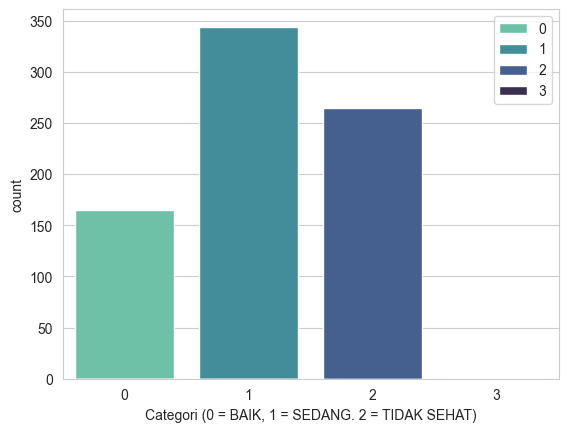

In [359]:
sns.countplot(x='categori', data=df, hue='categori', palette="mako_r", dodge=False)
plt.xlabel("Categori (0 = BAIK, 1 = SEDANG. 2 = TIDAK SEHAT)")
plt.legend(title=None) 
plt.show()

**Data Cleaning**

* mengecek apakah ada missing value maupun data yang duplikat


In [360]:
df.isnull().sum()

tanggal      0
stasiun      0
pm10        32
pm25        43
so2         22
co          13
o3          36
no2         15
max          0
critical     0
categori     0
dtype: int64

In [361]:
df.duplicated().sum()

0

* isi dengan nilai median

In [362]:
df = df.fillna(df.median(numeric_only=True))

cek kembali

In [363]:
df.isnull().sum()

tanggal     0
stasiun     0
pm10        0
pm25        0
so2         0
co          0
o3          0
no2         0
max         0
critical    0
categori    0
dtype: int64


* Menghapus kolom dan error value yang tidak diperlukan 

In [364]:
df = df.drop('tanggal', axis=1)
df = df.drop('stasiun', axis=1)
df = df.drop('max', axis=1)
df = df.drop('critical', axis=1)


df.head()

,pm10,pm25,so2,co,o3,no2,categori
0,41.0,86.0,37.0,14.0,35.0,4.0,0
1,38.0,53.0,29.0,6.0,31.0,13.0,1
2,27.0,46.0,27.0,7.0,47.0,7.0,0
3,44.0,58.0,25.0,7.0,40.0,13.0,1
4,30.0,48.0,24.0,4.0,32.0,7.0,0


In [365]:
df = df[df.categori != 3]

df.head()


,pm10,pm25,so2,co,o3,no2,categori
0,41.0,86.0,37.0,14.0,35.0,4.0,0
1,38.0,53.0,29.0,6.0,31.0,13.0,1
2,27.0,46.0,27.0,7.0,47.0,7.0,0
3,44.0,58.0,25.0,7.0,40.0,13.0,1
4,30.0,48.0,24.0,4.0,32.0,7.0,0


* Normalisai data menggunakan min max scaler

In [366]:
%matplotlib inline

Pemilihan rentang dilakukan sebelumnya, misalnya (0, 1), (-1, 1), atau rentang kustom sesuai kebutuhan.

Xscaled = X - Xmin / Xmax - Xmin

In [367]:
columns_to_normalize = ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2']

scaler = MinMaxScaler()

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head()

,pm10,pm25,so2,co,o3,no2,categori
0,0.158537,0.428571,0.430380,0.285714,0.188811,0.000000,0
1,0.140244,0.214286,0.329114,0.095238,0.160839,0.152542,1
2,0.073171,0.168831,0.303797,0.119048,0.272727,0.050847,0
3,0.176829,0.246753,0.278481,0.119048,0.223776,0.152542,1
4,0.091463,0.181818,0.265823,0.047619,0.167832,0.050847,0


In [368]:
df.corr()

,pm10,pm25,so2,co,o3,no2,categori
pm10,1.000000,0.805093,0.487488,0.400978,0.299966,0.492814,0.805703
pm25,0.805093,1.000000,0.360798,0.354685,0.229771,0.477632,0.818673
so2,0.487488,0.360798,1.000000,0.000705,0.352333,0.105760,0.412989
co,0.400978,0.354685,0.000705,1.000000,0.036114,0.500929,0.374179
o3,0.299966,0.229771,0.352333,0.036114,1.000000,0.010181,0.194969
no2,0.492814,0.477632,0.105760,0.500929,0.010181,1.000000,0.482279
categori,0.805703,0.818673,0.412989,0.374179,0.194969,0.482279,1.000000


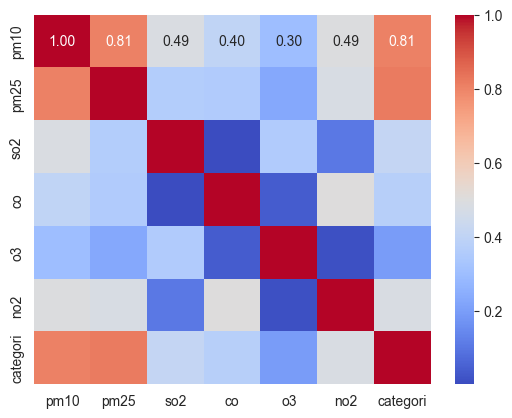

In [369]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan heatmap dari matriks korelasi
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


In [370]:
joblib.dump(scaler, open('models/MinMaxScaler.pkl', 'wb'))

**Feature Selection**

* Correlation untuk melihat seberapa berpengaruh feature dengan variable target

In [371]:
corr_matrix = df.corr()['categori']
print(corr_matrix)

pm10        0.805703
pm25        0.818673
so2         0.412989
co          0.374179
o3          0.194969
no2         0.482279
categori    1.000000
Name: categori, dtype: float64


# **Predict**

Feature target harus dihapus dari dataset karena target adalah variabel dependen yang ingin diprediksi oleh model.

In [372]:
y = df.categori.values
x_data = df.drop(['categori'], axis = 1)

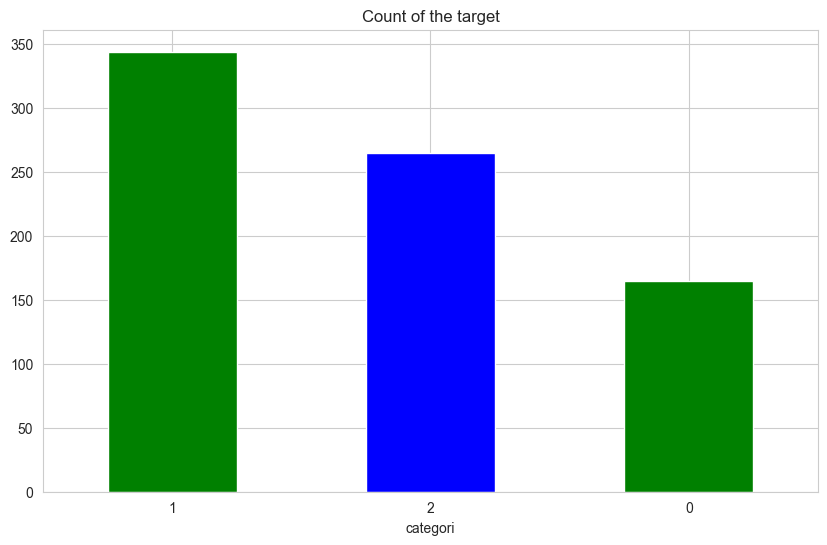

In [373]:
df['categori'].value_counts().plot(kind='bar',figsize=(10,6),color=['green','blue'])
plt.title("Count of the target")
plt.xticks(rotation=0);

**Balancing data**

imbalanced data menggunakan SMOTE

Original dataset shape Counter({1: 344, 2: 265, 0: 165})
Resampled ytrain dataset shape Counter({0: 344, 1: 344, 2: 344})


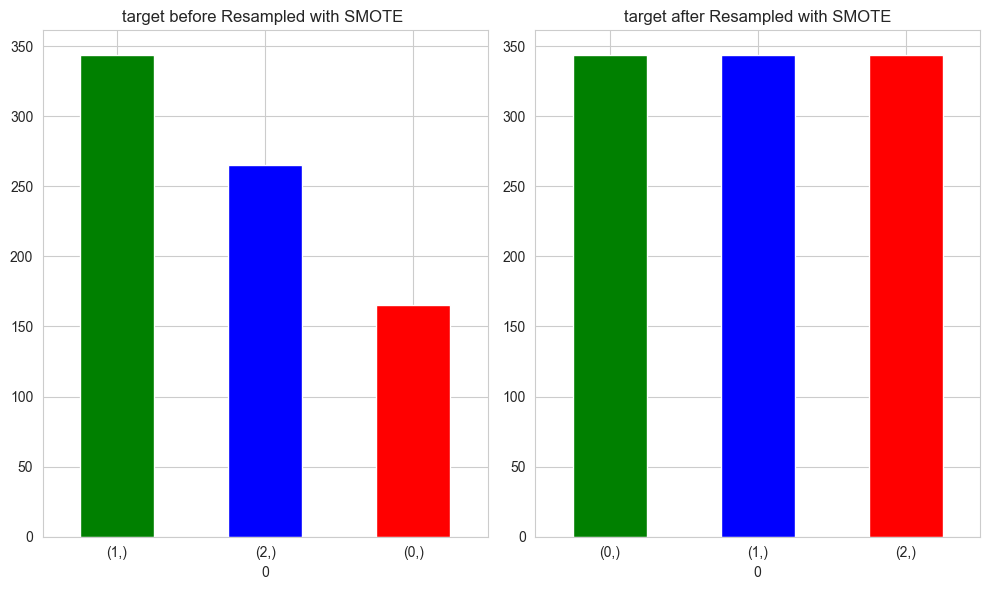

In [374]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=0)
print('Original dataset shape %s' % Counter(y))
x_train_smote, y_train_smote = smote.fit_resample(x_data, y)
print('Resampled ytrain dataset shape %s' % Counter(y_train_smote))

#Visualisasi

plt.figure(figsize=(12,4))

new_df1 = pd.DataFrame(data=y)
plt.subplot(1, 2, 1)
new_df1.value_counts().plot(kind='bar',figsize=(10,6),color=['green','blue','red','yellow'])
plt.title("target before Resampled with SMOTE ")
plt.xticks(rotation=0);


new_df2 = pd.DataFrame(data=y_train_smote)
plt.subplot(1, 2, 2)
new_df2.value_counts().plot(kind='bar',figsize=(10,6),color=['green','blue','red','yellow'])
plt.title("target after Resampled with SMOTE")
plt.xticks(rotation=0);
plt.tight_layout()
plt.show()

**Splitting data**

* Normalize

data telah dinormalisasi sebelum model dibuat. Namun, when the model created, data uji harus dinormalisasi kembali menggunakan parameter yang sama dengan data pelatihan. Hal ini dilakukan untuk memastikan bahwa data uji memiliki skala yang sama dengan data pelatihan dan agar model dapat memberikan hasil yang akurat.

In [375]:
x = (x_train_smote - np.min(x_train_smote)) / (np.max(x_train_smote) - np.min(x_train_smote))

* Training Testing

In [376]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y,test_size = 0.3,random_state=0)


Transpose adalah operasi yang menukar baris menjadi kolom dan sebaliknya pada matriks.

In [377]:
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

**Creating Model**

Disini saya mencoba 3 algoritma yaitu = KNN, SVM dan Naive Bayes

* KNN

untuk KNN Nilai k terbaik adalah 5 dan Akurasi terbaik adalah 86.70%

In [378]:
accuracies = {}

In [379]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 2)  # n_neighbors means k
knn.fit(x_train.T, y_train.T)
prediction = knn.predict(x_test.T)

print("{} NN Score: {:.2f}%".format(2, knn.score(x_test.T, y_test.T)*100))

2 NN Score: 78.54%


Nilai k terbaik adalah 5
Akurasi terbaik adalah 86.70%


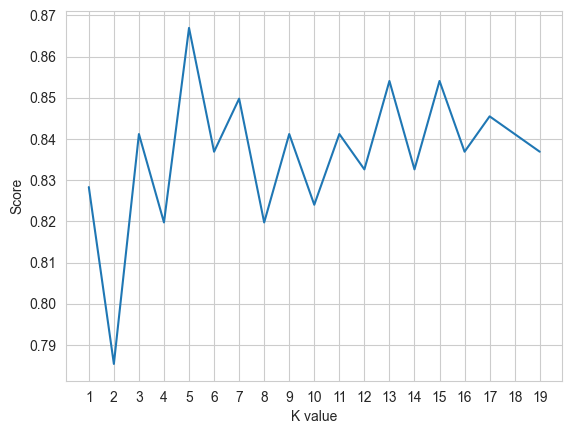

In [380]:
scoreList = []
for i in range(1, 20):
    knn2 = KNeighborsClassifier(n_neighbors = i)
    knn2.fit(x_train.T, y_train.T)
    scoreList.append(knn2.score(x_test.T, y_test.T))

optimal_k = scoreList.index(max(scoreList)) + 1
print("Nilai k terbaik adalah", optimal_k)
print("Akurasi terbaik adalah {:.2f}%".format(max(scoreList)*100))

plt.plot(range(1, 20), scoreList)
plt.xticks(np.arange(1, 20, 1))
plt.xlabel("K value")
plt.ylabel("Score")

acc = max(scoreList)*100
accuracies['KNN'] = acc

# Save the model
filename = 'KNN_Model.pkl'
pickle.dump(knn2, open(filename, 'wb'))

plt.show()


* SVM

Untuk SVM Parameter terbaik yaitu:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'} dengan Skor akurasi:  0.92

In [381]:
svm = SVC(kernel='rbf', C=1, gamma=2)
svm = svm.fit(x_train.T, y_train.T)
prediction = svm.predict(x_test.T)


print("Test Accuracy of SVM Algorithm: {:.2f}%".format(acc))

Test Accuracy of SVM Algorithm: 86.70%


In [382]:
svm = SVC()
param_grid = [
  {'C': [0.5, 1, 10, 100], 'kernel': ['linear']},
  {'C': [0.5, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.5, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['poly']},
  {'C': [0.5, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['sigmoid']}
]


grid_search = GridSearchCV(svm, param_grid)

grid_search.fit(x_train.T, y_train.T)

acc = grid_search.best_score_*100
accuracies['SVM'] = acc

# Save the model
filename = 'models/SVM_Model.pkl'
pickle.dump(grid_search, open(filename, 'wb'))

print("Parameter terbaik: ", grid_search.best_params_)
print("Skor akurasi: ", grid_search.best_score_)

Parameter terbaik:  {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Skor akurasi:  0.927964661909616


* Naive Bayes

In [383]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train.T, y_train.T)

acc = nb.score(x_test.T,y_test.T)*100
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.2f}%".format(acc))

Accuracy of Naive Bayes: 82.40%


* Comparing models

c:\Users\Asus\OneDrive\Documents\Skripsi\Predict\.venv\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


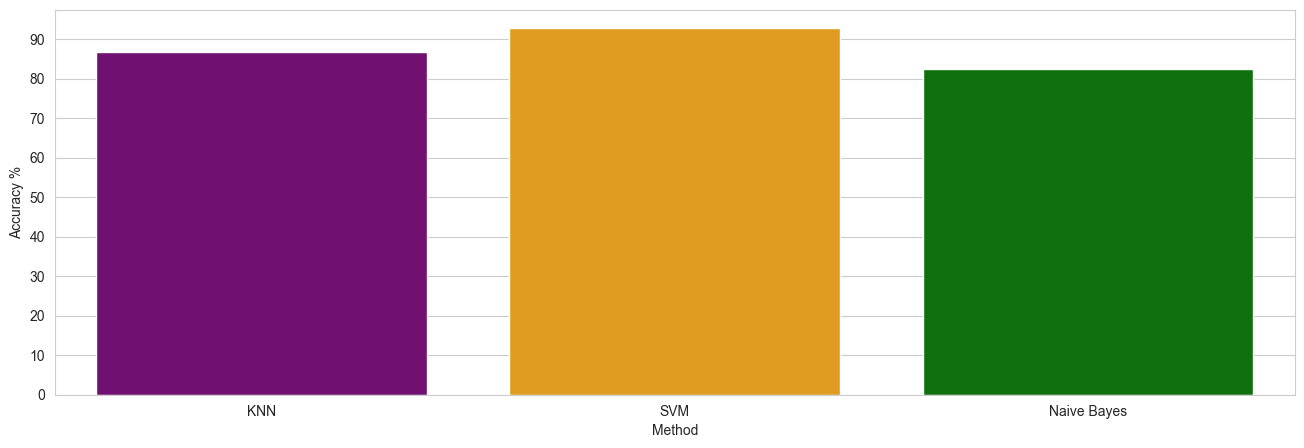

In [384]:
colors = ["purple", "orange", "green"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Method")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

* Confusion Matrix

KNN

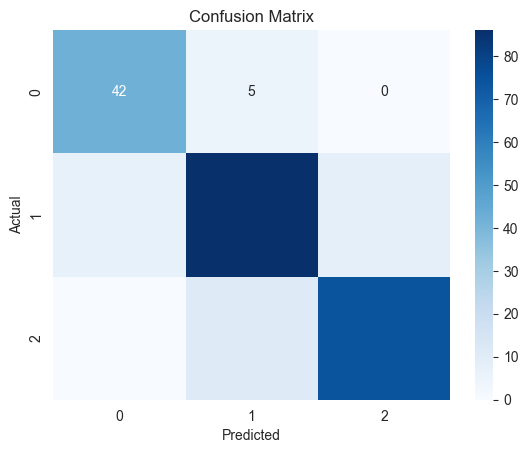

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        47
           1       0.84      0.85      0.85       101
           2       0.90      0.87      0.89        85

    accuracy                           0.87       233
   macro avg       0.87      0.87      0.87       233
weighted avg       0.87      0.87      0.87       233



In [385]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(x_train.T, y_train.T)
y_pred = knn.predict(x_test.T)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(y_test, y_pred)
print(report)

SVM

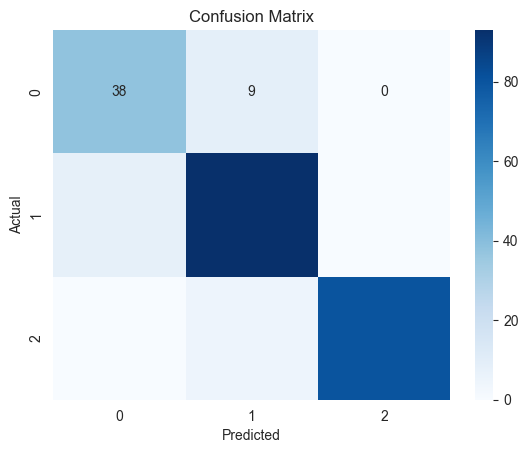

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        47
           1       0.87      0.92      0.89       101
           2       1.00      0.94      0.97        85

    accuracy                           0.91       233
   macro avg       0.90      0.89      0.89       233
weighted avg       0.91      0.91      0.91       233



In [386]:
svm = SVC(kernel='rbf', C=100, gamma=1).fit(x_train.T, y_train.T)
y_pred = svm.predict(x_test.T)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(y_test, y_pred)
print(report)


Naive Bayes

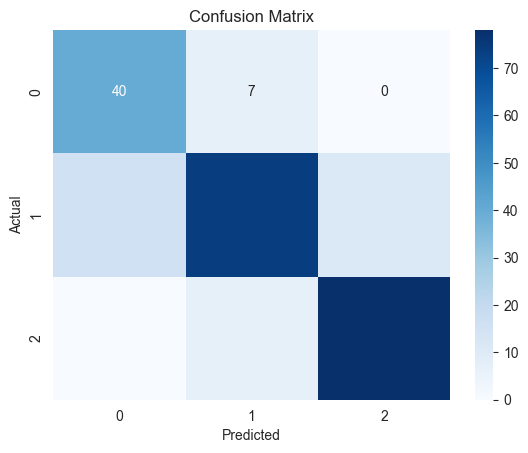

              precision    recall  f1-score   support

           0       0.71      0.85      0.78        47
           1       0.84      0.73      0.78       101
           2       0.88      0.92      0.90        85

    accuracy                           0.82       233
   macro avg       0.81      0.83      0.82       233
weighted avg       0.83      0.82      0.82       233



In [387]:
nb = GaussianNB()
nb.fit(x_train.T, y_train.T)
y_pred = nb.predict(x_test.T)

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

report = classification_report(y_test, y_pred)
print(report)


* Try with new data

In [388]:
filename = 'models/SVM_Model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

new_data = pd.DataFrame({'pm10': [22], 'pm25': [0.14653], 'so2': [12], 'co': [0.12], 'o3': [1.03825], 'no2': [9]})
print(new_data)
new_data_normalized = scaler.transform(new_data)
print(new_data_normalized)
# Predict the class of the new data
predicted_class = loaded_model.predict(new_data_normalized)

if predicted_class == 0:
    print(predicted_class, ": BAIK")
elif predicted_class == 1:
    print(predicted_class, ": SEDANG")
else:
    print(predicted_class, ": TIDAK SEHAT")


   pm10     pm25  so2    co       o3  no2
0    22  0.14653   12  0.12  1.03825    9
[[ 0.04268293 -0.12891864  0.11392405 -0.0447619  -0.04868357  0.08474576]]
[0] : BAIK


c:\Users\Asus\OneDrive\Documents\Skripsi\Predict\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
